In [1]:
# core
import pandas as pd
import numpy as np

# visual
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# baseline models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# metrics helper
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             ConfusionMatrixDisplay)

RANDOM_STATE = 42


In [2]:
df = pd.read_csv("credit_risk_dataset.csv")
display(df.head())
df.info()
df.describe()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [3]:
print(df.loan_status.value_counts(normalize=True).rename("proportion"))

loan_status
0    0.781836
1    0.218164
Name: proportion, dtype: float64


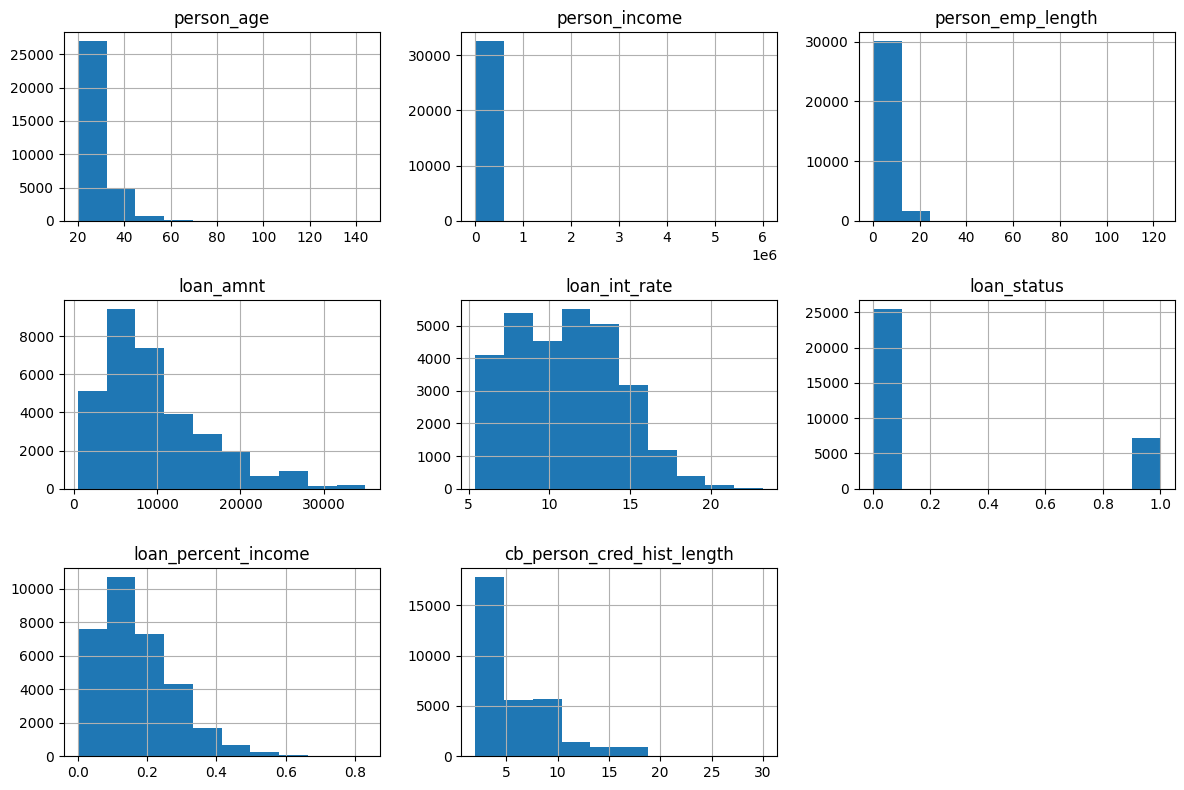

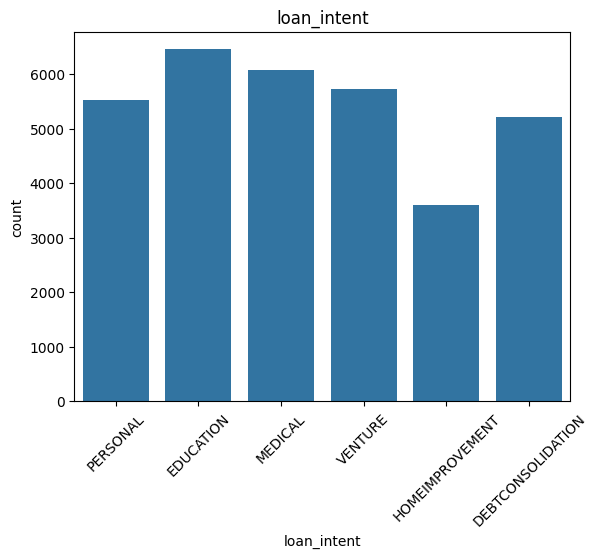

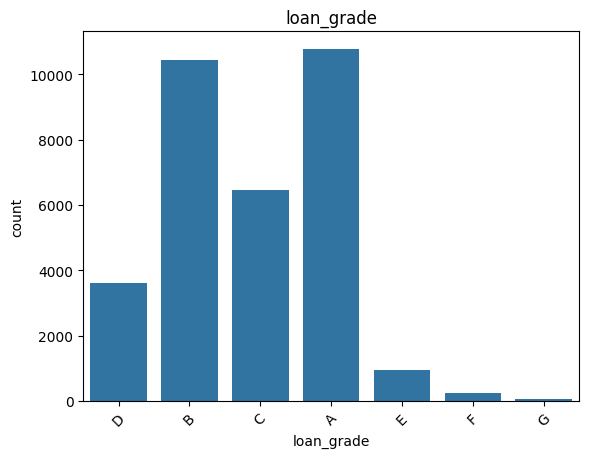

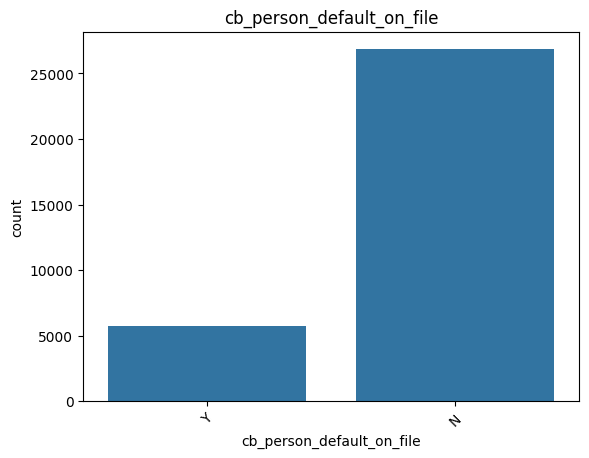

In [4]:
# numeric distributions
df.hist(figsize=(12, 8))
plt.tight_layout()

# categorical counts
cat_cols = ["person_home_ownership", "loan_intent", "loan_grade",
            "cb_person_default_on_file"]
for c in cat_cols:
    sns.countplot(data=df, x=c)
    plt.xticks(rotation=45)
    plt.title(c)
    plt.show()

<Axes: >

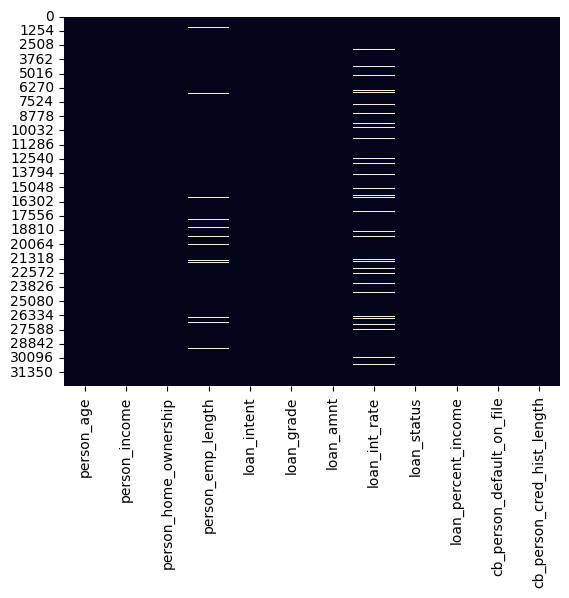

In [5]:
sns.heatmap(df.isna(), cbar=False)

In [6]:
# Phase 1 – Data Cleaning: Handling Missing Values

# Checking initial missing values
print("Missing values before cleaning:")
print(df.isnull().sum())

# 1. Fill missing categorical column with mode
df['person_home_ownership'].fillna(df['person_home_ownership'].mode()[0], inplace=True)

# 2. Fill missing employment length (numeric/ordinal) with median
df['person_emp_length'].fillna(df['person_emp_length'].median(), inplace=True)

# 3. Fill loan amount and interest rate (continuous) with median
df['loan_amnt'].fillna(df['loan_amnt'].median(), inplace=True)
df['loan_int_rate'].fillna(df['loan_int_rate'].median(), inplace=True)

# 4. Fill missing loan grade (if needed) with 'UNKNOWN'
df['loan_grade'].fillna('UNKNOWN', inplace=True)

# 5. (Optional) If loan_percent_income has missing values, recompute it
if df['loan_percent_income'].isnull().sum() > 0:
    df['loan_percent_income'] = df['loan_amnt'] / df['person_income']

# Verify all missing values handled
print("\nMissing values after cleaning:")
print(df.isnull().sum())


Missing values before cleaning:
person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

Missing values after cleaning:
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64


C:\Users\VatsaL\AppData\Local\Temp\ipykernel_27612\1409397623.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['person_home_ownership'].fillna(df['person_home_ownership'].mode()[0], inplace=True)
C:\Users\VatsaL\AppData\Local\Temp\ipykernel_27612\1409397623.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting

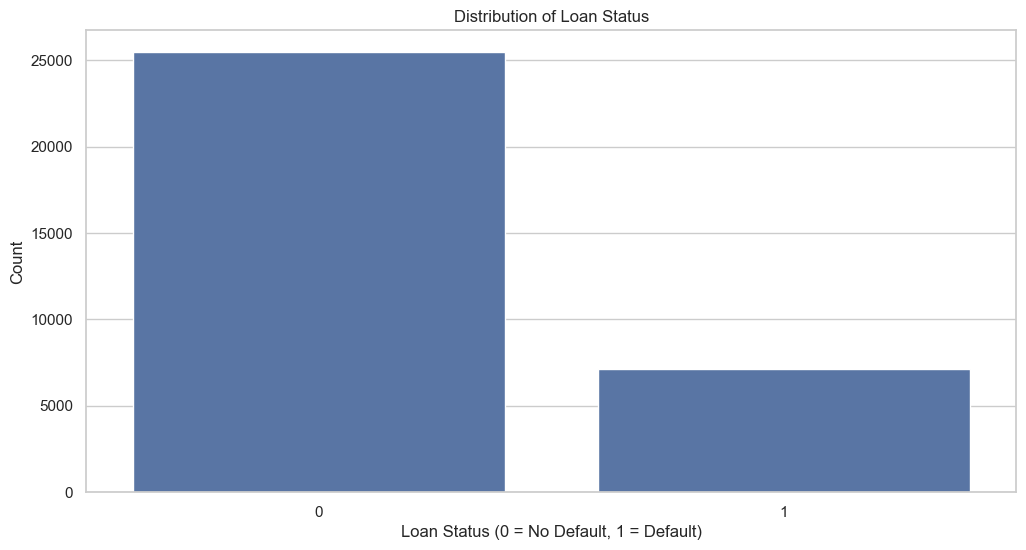

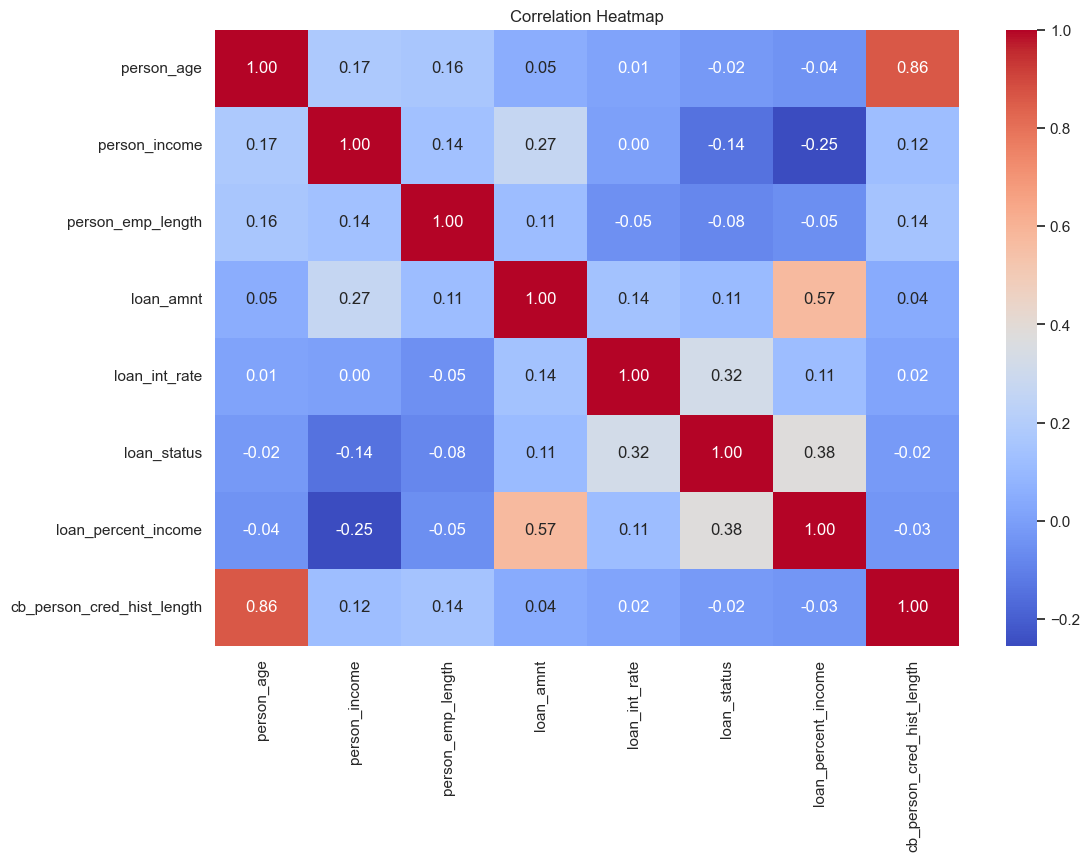

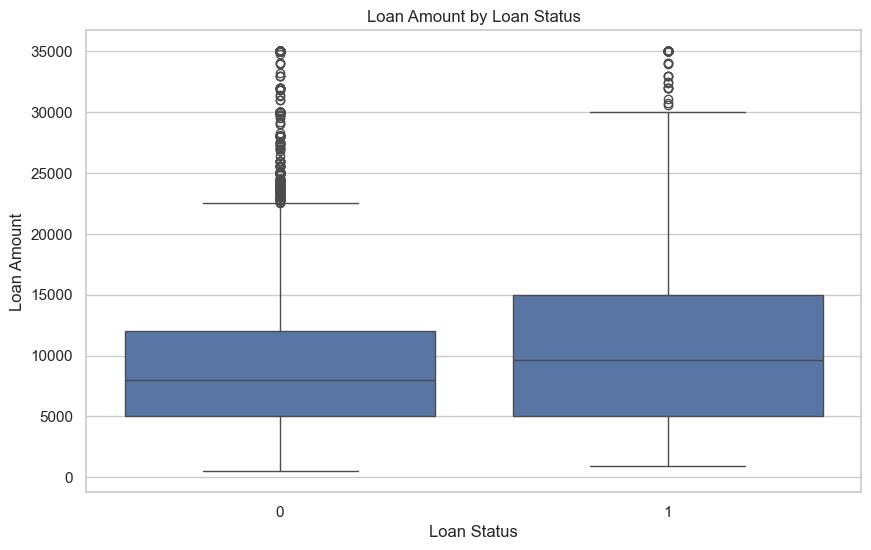

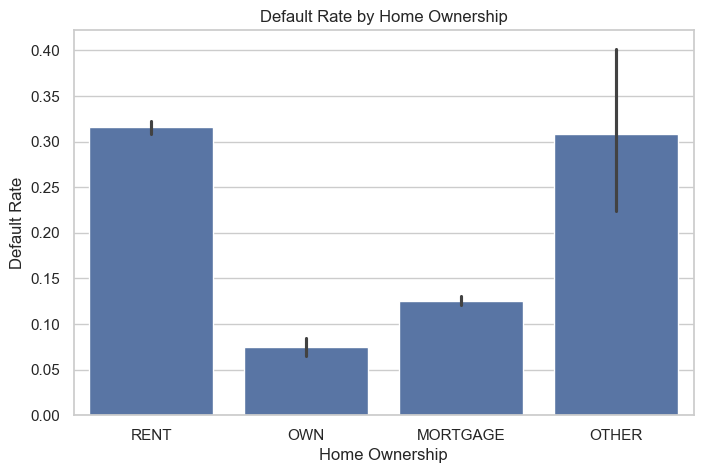

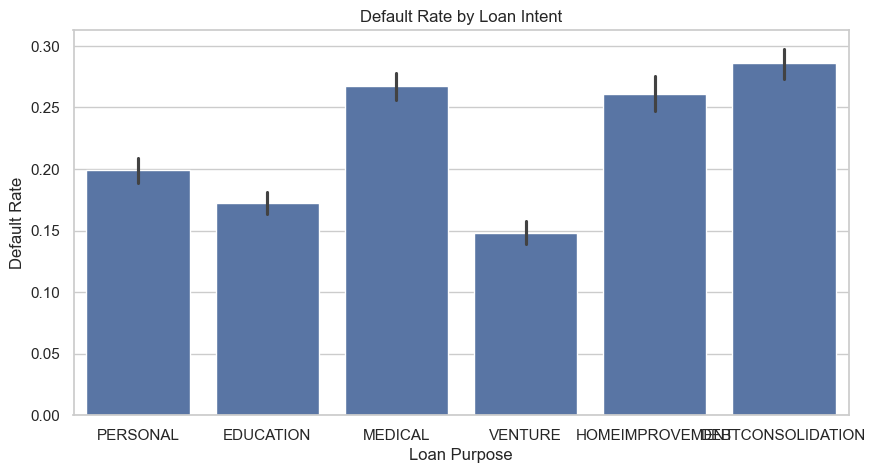

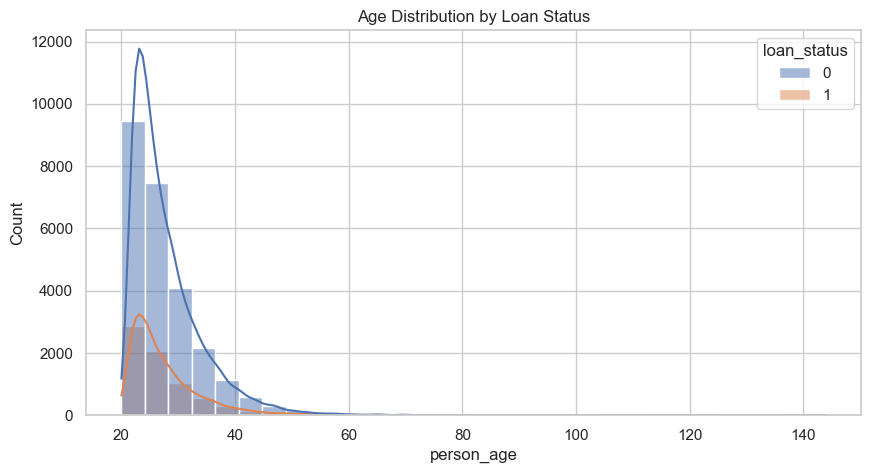

In [7]:
# Set style
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# 1. Target Variable Distribution
sns.countplot(x='loan_status', data=df)
plt.title("Distribution of Loan Status")
plt.xlabel("Loan Status (0 = No Default, 1 = Default)")
plt.ylabel("Count")
plt.show()

# 2. Correlation Heatmap (only numeric)
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# 3. Loan Amount vs. Default
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='loan_amnt', data=df)
plt.title("Loan Amount by Loan Status")
plt.xlabel("Loan Status")
plt.ylabel("Loan Amount")
plt.show()

# 4. Default Rate by Home Ownership
plt.figure(figsize=(8, 5))
sns.barplot(x='person_home_ownership', y='loan_status', data=df)
plt.title("Default Rate by Home Ownership")
plt.ylabel("Default Rate")
plt.xlabel("Home Ownership")
plt.show()

# 5. Default Rate by Loan Intent
plt.figure(figsize=(10, 5))
sns.barplot(x='loan_intent', y='loan_status', data=df)
plt.title("Default Rate by Loan Intent")
plt.ylabel("Default Rate")
plt.xlabel("Loan Purpose")
plt.show()

# 6. Age distribution by loan status
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='person_age', hue='loan_status', kde=True, bins=30)
plt.title("Age Distribution by Loan Status")
plt.show()

In [13]:
# ░▒▓  Phase 3 – FINAL DATA PREP  ▓▒░
from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import StandardScaler
import pandas as pd

# 1️⃣  Clean: already handled missing values in Phase 1
df_cleaned = df.dropna()

# 2️⃣  Encode categoricals ➜ one-hot (0/1)
cat_cols = ["person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file" ]
df_encoded = pd.get_dummies(df_cleaned, columns=cat_cols, drop_first=True)

# 3️⃣  Split features / target
X = df_encoded.drop("loan_status", axis=1)
y = df_encoded["loan_status"]

# 4️⃣  Train/test split  (stratify keeps class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# 5️⃣  Fit scaler *only on training numeric columns*
num_cols = X_train.select_dtypes(include="number").columns   # dummies stay as-is (0/1)

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled  = X_test.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols]  = scaler.transform(X_test[num_cols])

print(f"Shapes — raw: {X_train.shape}, scaled: {X_train_scaled.shape}")



Shapes — raw: (26064, 22), scaled: (26064, 22)


In [15]:
from sklearn.linear_model   import LogisticRegression
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.ensemble       import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline       import Pipeline
from sklearn.preprocessing  import StandardScaler
from sklearn.metrics        import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd, numpy as np

# --- Helper function to choose scaled or unscaled features
def fit_predict(model, use_scaled):
    if use_scaled:
        model.fit(X_train_scaled, y_train)
        return model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        return model.predict(X_test)

# --- Define models and whether they use scaled input
MODELS = {
    "Logistic Regression": (
        Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=1000))]),
        True,
    ),
    "KNN (k=15)": (
        Pipeline([("scaler", StandardScaler()), ("clf", KNeighborsClassifier(n_neighbors=15))]),
        True,
    ),
    "Random Forest": (
        RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=0, class_weight="balanced"),
        False,
    ),
    "Gradient Boosting": (
        GradientBoostingClassifier(random_state=0),
        False,
    ),
}

# --- Run each model and store results
rows = []
for name, (model, scaled) in MODELS.items():
    y_pred = fit_predict(model, scaled)
    rows.append({
        "Model": name,
        "Accuracy":  accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall":    recall_score(y_test, y_pred),
        "F1-score":  f1_score(y_test, y_pred),
        "Support":   y_test.shape[0],
    })

# --- Save results as DataFrame
baseline_results = pd.DataFrame(rows).sort_values("F1-score", ascending=False).reset_index(drop=True)

# --- Format output nicely
baseline_results.style.format({
    "Accuracy": "{:.4f}",
    "Precision": "{:.4f}",
    "Recall": "{:.4f}",
    "F1-score": "{:.4f}",
    "Support": "{:d}"
})


,Model,Accuracy,Precision,Recall,F1-score,Support
0,Random Forest,0.9319,0.9666,0.7124,0.8202,6517
1,Gradient Boosting,0.9217,0.9214,0.7011,0.7963,6517
2,KNN (k=15),0.8963,0.8877,0.6006,0.7164,6517
3,Logistic Regression,0.8674,0.7678,0.5626,0.6494,6517


Fitting 5 folds for each of 18 candidates, totalling 90 fits

Random Forest  best F1 (CV) = 0.8203
Best params: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Gradient Boosting  best F1 (CV) = 0.8328
Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}


,Model,Accuracy,Precision,Recall,F1-score,ROC-AUC
0,Gradient Boosting (tuned),0.9354,0.9639,0.7314,0.8317,0.9531
1,Random Forest (tuned),0.9293,0.9388,0.7229,0.8168,0.9330


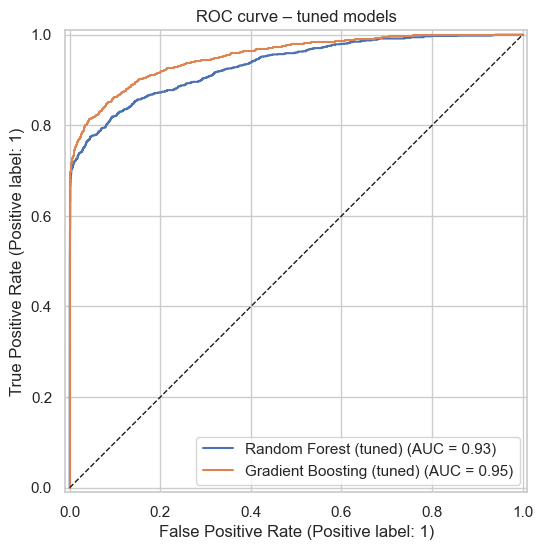

In [17]:
# --------------------------------------------------------------------------
# Phase 5 – Hyper-parameter tuning + cross-validation
# --------------------------------------------------------------------------
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score, roc_auc_score,
                             RocCurveDisplay)
import matplotlib.pyplot as plt
import pandas as pd

# ──────────────────────────────────────────────────────────────────────────
# 1️⃣ Define search spaces (keep small at first; can expand later)
# ──────────────────────────────────────────────────────────────────────────
rf_grid = {
    "n_estimators": [200, 350, 500],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "class_weight": ["balanced"]
}

gb_grid = {
    "n_estimators":  [200, 300],
    "learning_rate": [0.03, 0.1],
    "max_depth":     [3, 5]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def grid_search(model, param_grid, name):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,
        scoring="f1",
        n_jobs=-1,
        verbose=1
    )
    gs.fit(X_train, y_train)  # no scaling needed for trees
    print(f"\n{name}  best F1 (CV) = {gs.best_score_:.4f}")
    print("Best params:", gs.best_params_)
    return gs.best_estimator_

# ──────────────────────────────────────────────────────────────────────────
# 2️⃣ Run the searches
# ──────────────────────────────────────────────────────────────────────────
best_rf = grid_search(RandomForestClassifier(random_state=0), rf_grid, "Random Forest")
best_gb = grid_search(GradientBoostingClassifier(random_state=0), gb_grid, "Gradient Boosting")

# ──────────────────────────────────────────────────────────────────────────
# 3️⃣ Evaluate tuned models on the unseen test set
# ──────────────────────────────────────────────────────────────────────────
def evaluate(estimator, Xte, yte, label):
    y_pred = estimator.predict(Xte)
    y_prob = estimator.predict_proba(Xte)[:, 1]

    return {
        "Model":      label,
        "Accuracy":   accuracy_score (yte, y_pred),
        "Precision":  precision_score(yte, y_pred),
        "Recall":     recall_score   (yte, y_pred),
        "F1-score":   f1_score       (yte, y_pred),
        "ROC-AUC":    roc_auc_score  (yte, y_prob)
    }, y_prob

rows, probs = [], {}
for est, name in [(best_rf, "Random Forest (tuned)"), (best_gb, "Gradient Boosting (tuned)")]:
    metrics, probas = evaluate(est, X_test, y_test, name)
    rows.append(metrics)
    probs[name] = probas

results_tuned = pd.DataFrame(rows).sort_values("F1-score", ascending=False).reset_index(drop=True)

# Format only numeric columns
numeric_cols = ["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"]
display(results_tuned.style.format({col: "{:.4f}" for col in numeric_cols}))

# ──────────────────────────────────────────────────────────────────────────
# 4️⃣ ROC-AUC comparison plot
# ──────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(6, 6))
for label, p in probs.items():
    RocCurveDisplay.from_predictions(y_test, p, name=label, ax=plt.gca())
plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.title("ROC curve – tuned models")
plt.show()


c:\Users\VatsaL\Desktop\Datasets\Credit Risk Modelling\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


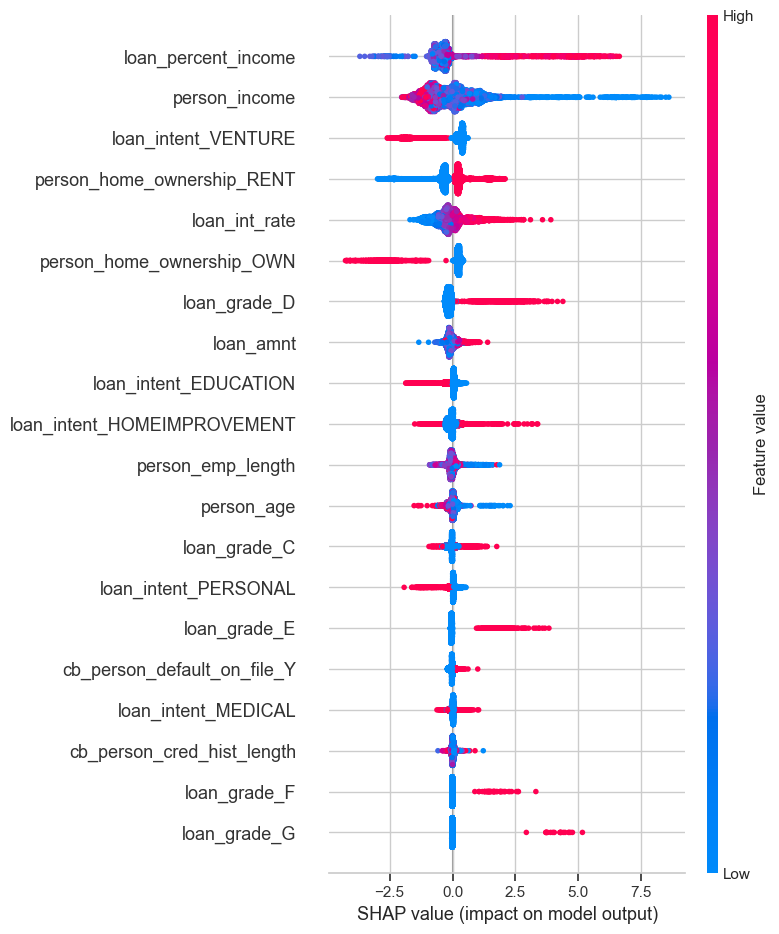

In [18]:
# Phase 6 – SHAP Explainability for Tree Models
import shap
import matplotlib.pyplot as plt

# Use TreeExplainer for Gradient Boosting
explainer = shap.TreeExplainer(best_gb)  # Use your tuned Gradient Boosting model
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)

In [19]:
# ------------------------------------------------------------------
# Cell A – persist the best Gradient-Boosting model (highest ROC-AUC)
# ------------------------------------------------------------------
import joblib, pathlib, datetime, json

OUT_DIR = pathlib.Path("artifacts")
OUT_DIR.mkdir(exist_ok=True)

timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M")
model_path = OUT_DIR / f"gbm_credit_risk_{timestamp}.joblib"

joblib.dump(best_gb, model_path)
print(f"✅  Saved tuned GradientBoostingClassifier →  {model_path}")

✅  Saved tuned GradientBoostingClassifier →  artifacts\gbm_credit_risk_20250626-1953.joblib


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,...,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
26446,31,102000,5.0,4000,7.88,0.04,10,False,False,False,...,False,False,False,False,False,False,False,False,False,False


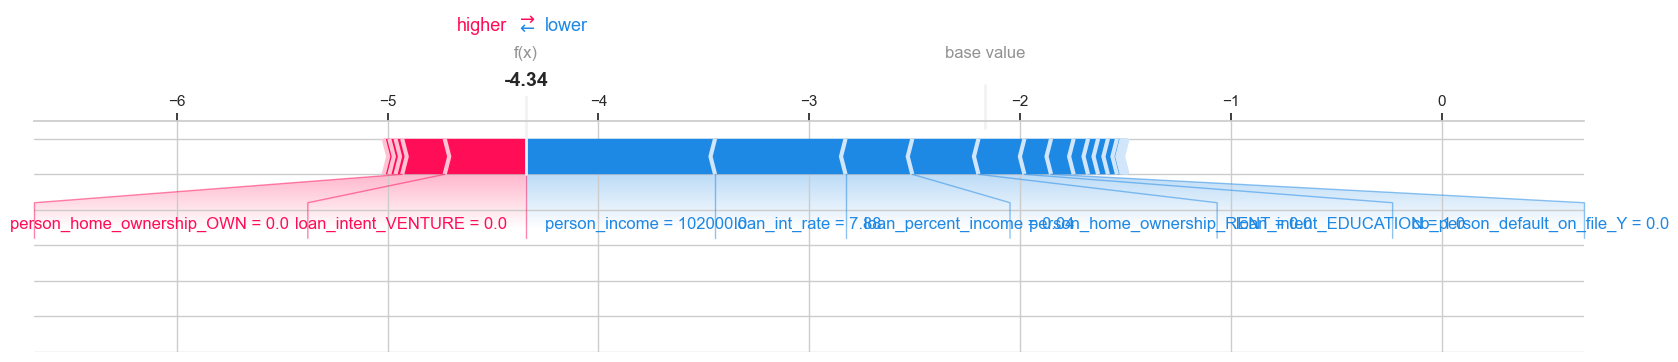

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,...,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
16181,24,112500,3.0,8600,13.11,0.08,4,False,False,False,...,False,False,False,False,True,False,False,False,False,False


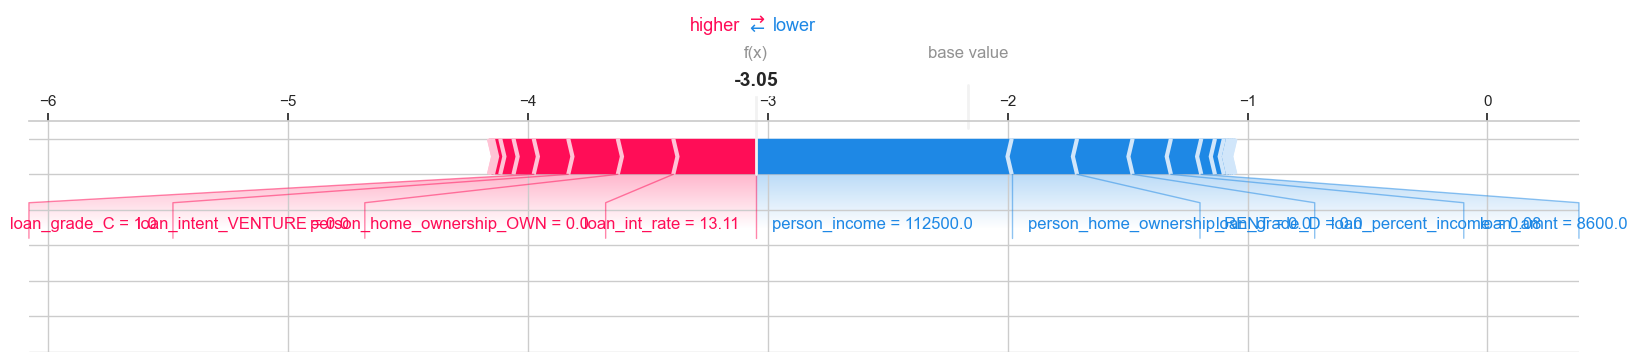

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,...,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
29277,38,83000,3.0,22250,23.22,0.27,12,False,False,True,...,False,False,False,False,False,False,False,False,True,True


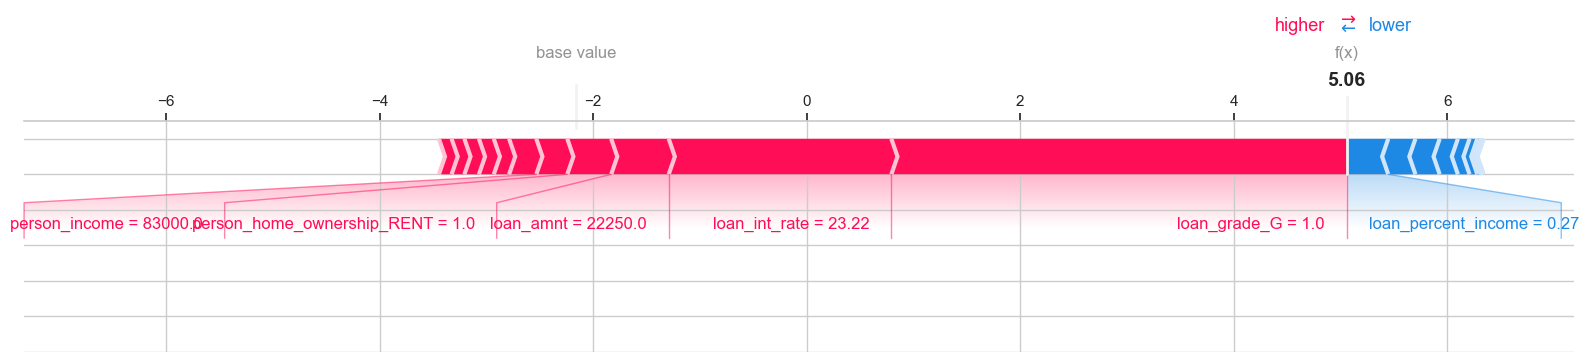

In [20]:
# ------------------------------------------------------------------
# Cell B – re-load + create SHAP explainer (TreeExplainer for GBM)
# ------------------------------------------------------------------
import shap
loaded_gbm = joblib.load(model_path)

explainer = shap.TreeExplainer(loaded_gbm)

# Use **scaled** or **raw** test matrix depending on how you trained.
# Here the GBM used *raw* features (no scaling).
shap_values = explainer.shap_values(X_test)

# ------------------------------------------------------------------
# Cell C – pick a few rows to visualise (SHAP force plot)
# ------------------------------------------------------------------
idx_examples = [10, 150, 300]          # pick any row indices you like

for idx in idx_examples:
    display(pd.DataFrame(X_test.iloc[idx]).T)   # show the raw feature values
    shap.force_plot(
        explainer.expected_value,
        shap_values[idx],
        X_test.iloc[idx],
        matplotlib=True # renders static image in notebooks
    )


In [21]:
# ------------------------------------------------------------------
# Cell D – save feature order & metadata
# ------------------------------------------------------------------
feat_path = OUT_DIR / f"gbm_features_{timestamp}.json"
with open(feat_path, "w") as fp:
    json.dump(list(X_train.columns), fp)

print("✅  Saved feature list  →", feat_path)

✅  Saved feature list  → artifacts\gbm_features_20250626-1953.json


In [22]:
import os
# Create directory if it doesn't exist
os.makedirs("artifacts", exist_ok=True)

# Save the model
joblib.dump(best_gb, "artifacts/gbm_credit_risk_model.pkl")

print("✅ Model saved to artifacts/gbm_credit_risk_model.pkl")

✅ Model saved to artifacts/gbm_credit_risk_model.pkl
